# Lab Assigment 2 Estimation of Apparent Motion

<p style="text-align:left;">
    José Pedro Cruz
    <span style="float:right;">
        up201504646
    </span>
</p>
<p style="text-align:left;">
    Martinho Figueiredo
    <span style="float:right;">
        up201506179
    </span>
</p>
<p style="text-align:left;">
    Nuno Nascimento
    <span style="float:right;">
        up201907933
    </span>
</p>


[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/martinhofigueiredo/VC)



In [1]:
import cv2
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib widget


In [2]:
# Loads a yaml file with the parameters to run the code
def load_config(filename):
    with open(filename, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    return config

In [3]:
# Find all jpgs and pngs in a folder and returns a list of their respective path 
def get_frame_paths(folder_path):
    frame_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            frame_path = os.path.join(folder_path, filename)
            frame_paths.append(frame_path)
    frame_paths.sort()
    return frame_paths

In [4]:
# Checks if the inut file is a directory and if it is it will try and get the frames inside the folder
# it will check if it is and mp4 and if it is it will read it and create a list of frames
def get_input_frames(input_path):
    if os.path.isdir(input_path):
        frame_paths = get_frame_paths(input_path)
        frames = [cv2.imread(frame_path) for frame_path in frame_paths]
    else :
        if input_path.endswith('.mp4'):
            cap = cv2.VideoCapture(input_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()
    return frames

# Lucas-Kanade

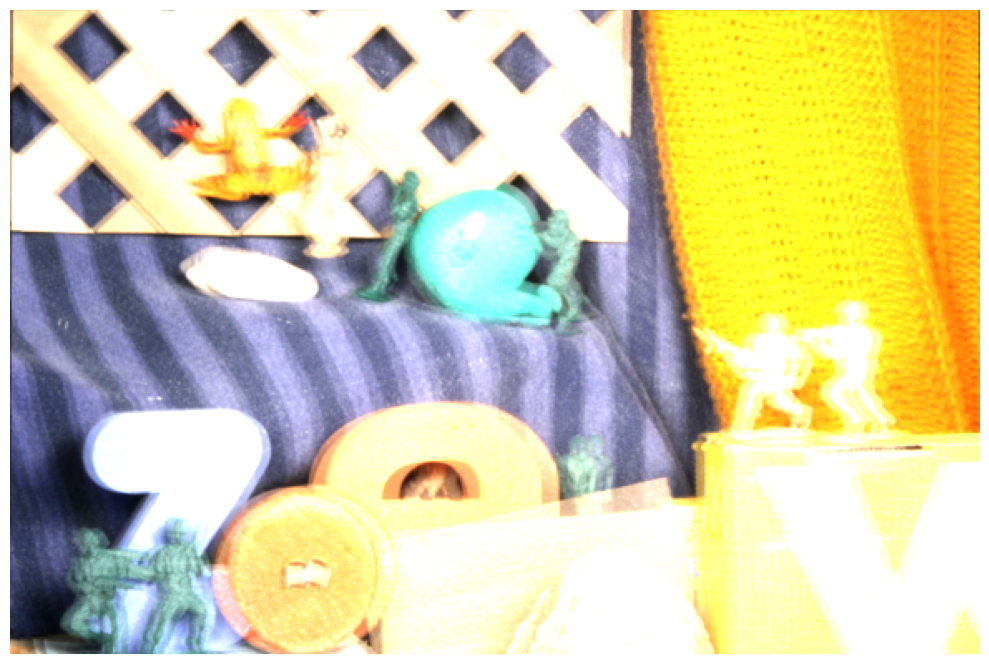

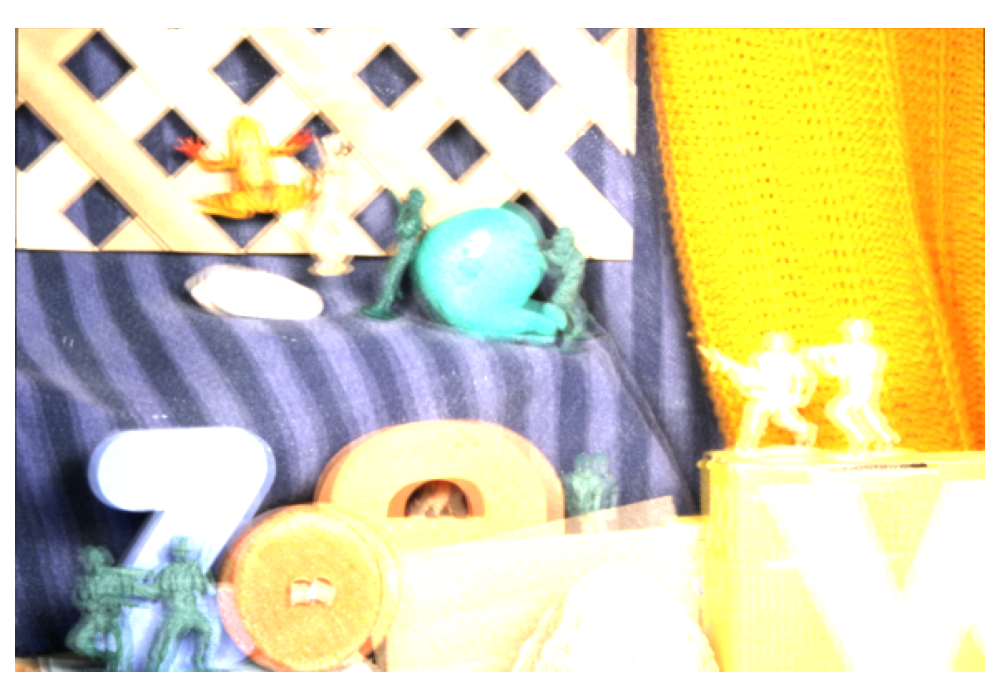

In [5]:
print(f"Loading File \'config_LK.yml\'")

config = load_config('config_LK.yml')

input_path = os.getcwd()+config['input_path']

frames = get_input_frames(input_path)


feature_params = dict(
    maxCorners=config['max_corners'],
    qualityLevel=config['quality_level'],
    minDistance=config['min_distance'],
    blockSize=config['block_size']
)
lk_params = dict(
    winSize=(config['window_size'], config['window_size']),
    maxLevel=config['max_level'],
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, config['max_iterations'], config['epsilon'])
)

prev_frame = frames[0]
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
prev_corners = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
prev_roi = cv2.boundingRect(prev_corners)

mask = np.zeros_like(prev_frame)

fig, ax = plt.subplots(figsize=(10, 7))

for curr_frame in frames[1:]:
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    curr_corners, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_corners, None, **lk_params)

    good_prev_corners = prev_corners[status == 1]
    good_curr_corners = curr_corners[status == 1]

    M, _ = cv2.findHomography(good_prev_corners, good_curr_corners, cv2.RANSAC, config['ransac_threshold'])

    warped_roi = cv2.warpPerspective(prev_frame, M, (curr_frame.shape[1], curr_frame.shape[0]))
    warped_mask = cv2.warpPerspective(mask, M, (curr_frame.shape[1], curr_frame.shape[0]))

    output = curr_frame.copy()
    output[warped_mask != 0] = 0
    output = cv2.add(output, warped_roi)

    ax.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.tight_layout()
    clear_output(wait=True)
    display(fig)

    prev_gray = curr_gray.copy()
    prev_corners = good_curr_corners.reshape(-1, 1, 2)
    prev_roi = cv2.boundingRect(prev_corners)

cv2.destroyAllWindows()


# Horn-Shunchk (?)

In [ ]:
# Load the tuning parameters from the config file
with open('config_HS.yml', 'r') as f:
    config = yaml.safe_load(f)

# Load the input frames
input_frames = get_input_frames(config['input_path'])

# Initialize the flow field for the first frame with zeros
prev_frame = input_frames[0]
flow = np.zeros((prev_frame.shape[0], prev_frame.shape[1], 2), dtype=np.float32)

# Set the Horn-Schunck parameters
alpha = config['alpha']
num_iterations = config['num_iterations']
epsilon = config['epsilon']

# Define the Gaussian pyramid levels
num_levels = config['num_levels']
pyramid_scale = config['pyramid_scale']

# Compute the optical flow for each level of the pyramid
for level in range(num_levels):
    # Downsample the input frames and flow field
    curr_frame = cv2.resize(prev_frame, None, fx=pyramid_scale, fy=pyramid_scale)
    curr_flow = cv2.resize(flow, None, fx=pyramid_scale, fy=pyramid_scale)

    # Compute the optical flow using the multi-channel Horn-Schunck algorithm
    for i in range(num_iterations):
        # Compute the gradient of the flow field
        fx, fy = np.split(curr_flow, 2, axis=2)
        
        # Compute the Laplacian of the flow field
        fxx, _ = np.gradient(fx)
        _, fyy = np.gradient(fy)
        
        # Compute the divergence of the flow field
        divergence = fxx + fyy
        
        # Compute the temporal derivative of the input frames
        dt = (curr_frame - prev_frame) / 255.0
        
        # Compute the update for the flow field
        update = np.zeros_like(curr_flow)
        for channel in range(curr_flow.shape[2]):
            update[:, :, channel] = (-divergence[:, :, channel] + 
                                     alpha * fx[:, :, channel] * dt**2 + 
                                     alpha * fy[:, :, channel] * dt**2) / 
                                     (fxx[:, :, channel] + fyy[:, :, channel] + epsilon)
        
        # Apply the update to the flow field
        curr_flow += update
        
    # Refine the flow field using the coarse-to-fine strategy
    if level > 0:
        curr_flow = cv2.resize(prev_flow, curr_flow.shape[::-1]) * 2 + curr_flow
        
    # Upsample the flow field to the next level of the pyramid
    prev_flow = curr_flow
    prev_frame = curr_frame

# Display the final flow field using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
flow_visualization = flow_to_color(prev_flow)
ax.imshow(flow_visualization)
ax.set_axis_off()
plt.show()


In [ ]:
import cv2
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ipywidgets import Image
from io import BytesIO
import PIL.Image

def get_input_frames(input_path):
    if os.path.isdir(input_path):
        frame_paths = get_frame_paths(input_path)
        frames = [cv2.imread(frame_path) for frame_path in frame_paths]
    else :
        if input_path.endswith('.mp4'):
            cap = cv2.VideoCapture(input_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()
    return frames

def display_image(image):
    # Convert the OpenCV image to a PIL image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = PIL.Image.fromarray(image)
    
    # Display the image using the Jupyter inline magic
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    display(Image(data=buffered.getvalue()))
    

def flow_to_color(flow, max_flow=None):
    """
    Convert optical flow to RGB image using the Middlebury color code.
    """
    assert flow.ndim == 3 and flow.shape[2] == 2, "input flow must have shape (H, W, 2)"
    if max_flow is None:
        max_flow = np.max(np.abs(flow))
    
    eps = 1e-5
    unknown_mask = np.logical_or(np.isnan(flow[..., 0]), np.isnan(flow[..., 1]))
    flow = flow / (max_flow + eps)
    flow[..., 0] = 0.5 + flow[..., 0] / 2
    flow[..., 1] = 0.5 - flow[..., 1] / 2
    flow[..., 1] *= -1
    flow[unknown_mask, :] = 0
    
    return (255 * flow).astype(np.uint8)

# Load the tuning parameters from the config file
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

# Load the input frames
input_frames = get_input_frames(config['input'])

# Initialize the flow field for the first frame with zeros
prev_frame = input_frames[0]
flow = np.zeros((prev_frame.shape[0], prev_frame.shape[1], 2), dtype=np.float32)

# Set the Horn-Schunck parameters
alpha = config['alpha']
num_iterations = config['num_iterations']
epsilon = config['epsilon']

# Define the Gaussian pyramid levels
num_levels = config['num_levels']
pyramid_scale = config['pyramid_scale']

# Create an output widget for displaying images
output_widget = Image()

# Compute the optical flow for each level of the pyramid
for level in range(num_levels):
    # Downsample the input frames and flow field
    curr_frame = cv2.resize(prev_frame, None, fx=pyramid_scale, fy=pyramid_scale)
    curr_flow = cv2.resize(flow, None, fx=pyramid_scale, fy=pyramid_scale)

    # Compute the optical flow using the multi-channel Horn-Schunck algorithm
    for i in range(num_iterations):
        # Compute the gradient of the flow field
        fx, fy = np.split(curr_flow, 2, axis=2)
        
        # Compute the Laplacian of the flow field
        fxx, _ = np.gradient(fx)
        _, fyy = np.gradient(fy)
        fxy = np.gradient(fx, axis=0)[0] + np.gradient(fy, axis=1)[1]
        
        # Compute the temporal derivative of the flow field
        ft = next_frame_gray - prev_frame_gray + np.sum(curr_flow * np.dstack((fx, fy)), axis=2)
        
        # Compute the update to the flow field
        numerator = fxx * fy ** 2 - 2 * fx * fy * fxy + fyy * fx ** 2 - ft * fx * fy
        denominator = fx ** 2 + fy ** 2 + alpha
        update = numerator / denominator[..., np.newaxis]
        
        # Update the flow field
        curr_flow += update
        
        # Visualize the current flow field
        if display:
            fig, ax = plt.subplots()
            ax.imshow(prev_frame_gray, cmap='gray')
            ax.quiver(x, y, curr_flow[..., 0], curr_flow[..., 1], color='red', angles='xy')
            ax.set_title('Iteration {}'.format(i + 1))
            plt.show()
        
    # Convert the flow field to polar coordinates
    magnitude, angle = cv2.cartToPolar(curr_flow[..., 0], curr_flow[..., 1], angleInDegrees=True)
    
    return curr_flow, magnitude, angle

